In [1]:
import os
import json
import numpy as np
import pandas as pd
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')
import warnings
warnings.filterwarnings("ignore")
import dill as pickle

In [2]:
df = pd.read_csv("training.csv")
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
test_df = pd.read_csv("test.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 62.4+ KB


In [5]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [6]:
df.describe(include=['O'])

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
count,614,601,611,599,614,582,614,614
unique,614,2,2,4,2,2,3,2
top,LP002036,Male,Yes,0,Graduate,No,Semiurban,Y
freq,1,489,398,345,480,500,233,422


In [7]:
df.Dependents.value_counts()

0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64

In [8]:
df.corr()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
ApplicantIncome,1.000000,-0.116605,0.570909,-0.045306,-0.014715
CoapplicantIncome,-0.116605,1.000000,0.188619,-0.059878,-0.002056
LoanAmount,0.570909,0.188619,1.000000,0.039447,-0.008433
Loan_Amount_Term,-0.045306,-0.059878,0.039447,1.000000,0.001470
Credit_History,-0.014715,-0.002056,-0.008433,0.001470,1.000000


<function matplotlib.pyplot.show>

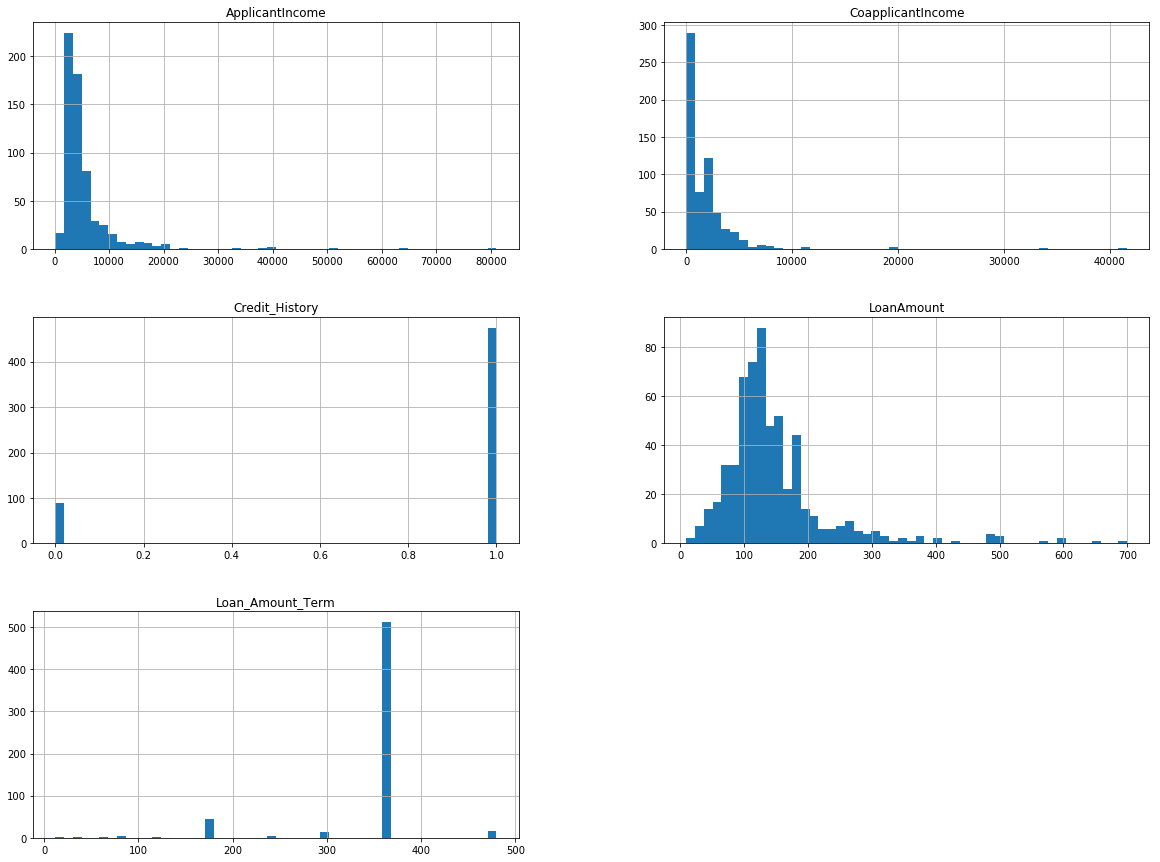

In [9]:
df.hist(bins=50,figsize=(20,15))
plt.show

In [10]:
df[['Credit_History','Education']].groupby('Education').mean().sort_values(by='Credit_History', ascending = False)

,Credit_History
Education,
Graduate,0.857788
Not Graduate,0.785124


In [11]:
import pdb

class PreProcessing(BaseEstimator, TransformerMixin):
    """Custom Pre-Processing estimator for our use-case
    """

    def __init__(self):
        pass

    def transform(self, df):
        """Regular transform() that is a help for training, validation & testing datasets
           (NOTE: The operations performed here are the ones that we did prior to this cell)
        """
 
        pred_var = ['Gender','Married','Dependents','Education','Self_Employed','ApplicantIncome',\
                    'CoapplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History','Property_Area']
    
        df = df[pred_var]
        df['Dependents'] = df['Dependents'].replace(['3+'],3)
        df['Gender'] = df['Gender'].fillna('Male')
        df["Married"] = df["Married"].fillna('Yes')
        df['Dependents'] = df.groupby('Married')['Dependents'].apply(lambda x: x.fillna\
                                                                               (1 if 'Yes' else 0))
        df["Self_Employed"] = df["Self_Employed"].fillna('No')
        df['Credit_History'] = df.groupby('Education')['Credit_History'].apply(lambda x: x.fillna\
                                                                               (1 if 'Graduate' else 0))
        
        
        married_values = {'No' : 0, 'Yes' : 1}
        gender_values = {'Female' : 0, 'Male' : 1} 
        education_values = {'Graduate' : 0, 'Not Graduate' : 1}
        property_values = {'Rural' : 0, 'Urban' : 1, 'Semiurban' : 2}
        employed_values = {'No' : 0, 'Yes' : 1}
#        pdb.set_trace()
        df.replace({'Gender': gender_values, 'Married': married_values, 'Education': education_values, \
                    'Self_Employed': employed_values, 'Property_Area': property_values}, inplace=True)
        
        
        df["Loan_Amount_Term"] = df["Loan_Amount_Term"].fillna(self.term_median_)
        df["LoanAmount"] = df["LoanAmount"].fillna(self.amt_median_)
    
        
        return df.as_matrix()

    def fit(self, df, y=None, **fit_params):
        """Fitting the Training dataset & calculating the required values from train
           e.g: We will need the mean of X_train['Loan_Amount_Term'] that will be used in
                transformation of X_test
        """

        self.term_median_ = df['Loan_Amount_Term'].median()
        self.amt_median_ = df['LoanAmount'].median()
        
        return self

In [12]:
pred_var = ['Gender','Married','Dependents','Education','Self_Employed','ApplicantIncome','CoapplicantIncome',\
            'LoanAmount','Loan_Amount_Term','Credit_History','Property_Area']

X_train, X_test, y_train, y_test = train_test_split(df[pred_var], df['Loan_Status'], test_size=0.25, random_state=42)

In [13]:
y_train = y_train.replace({'Y':1, 'N':0}).as_matrix()
y_test = y_test.replace({'Y':1, 'N':0}).as_matrix()

In [14]:
pipe = make_pipeline(PreProcessing(),StandardScaler(),
                    RandomForestClassifier())
pipe

Pipeline(steps=[('preprocessing', PreProcessing()), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
      ...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])

In [15]:
param_grid = {"randomforestclassifier__n_estimators" : [20, 30,40],
             "randomforestclassifier__max_depth" : [None, 6, 8, 10],
             "randomforestclassifier__max_leaf_nodes": [None, 5, 10, 20], 
             "randomforestclassifier__min_impurity_split": [0.2, 0.3,0.4]}
grid = GridSearchCV(pipe,param_grid=param_grid, cv=3)


In [16]:
grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('preprocessing', PreProcessing()), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
      ...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'randomforestclassifier__n_estimators': [20, 30, 40], 'randomforestclassifier__max_depth': [None, 6, 8, 10], 'randomforestclassifier__max_leaf_nodes': [None, 5, 10, 20], 'randomforestclassifier__min_impurity_split': [0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [17]:
print("Best parameters: {}".format(grid.best_params_))

Best parameters: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_leaf_nodes': 20, 'randomforestclassifier__min_impurity_split': 0.3, 'randomforestclassifier__n_estimators': 20}


In [18]:
print("Validation set score: {:.2f}".format(grid.score(X_test, y_test)))

Validation set score: 0.77


In [19]:
grid.predict(test_df)

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1,

In [20]:
filename = 'model_v1.pk'
with open(filename, 'wb') as file:
    pickle.dump(grid, file)

In [21]:
with open(filename ,'rb') as f:
    loaded_model = pickle.load(f)
    
loaded_model.predict(test_df)    

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1,

In [ ]:
        jcols = ['LoanAmount']
        icols = ['Gender','Married','Dependents','Education','Self_Employed','ApplicantIncome',\
                    'CoapplicantIncome','Credit_History','Property_Area']

        notnans = df[jcols].notnull().all(axis=1)
        df_notnans = df[notnans]
        rf = RandomForestRegressor()
        rf.fit(df_notnans[icols], df_notnans[jcols])
        df["LoanAmount"] = df["LoanAmount"].fillna(pd.Series(rf.predict(df[icols])))
        